In [1]:

# from typing import List
import rasterio
from rasterio.plot import show
import numpy as np
import os
import numpy as np


import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib as mpl
from PIL import ImageEnhance
from skimage import io

Создаем tiff файлы с геоданными

In [2]:
# import os
# import numpy as np
# import rasterio


# def createTiffGeofile(path, pathToNewFile):
#     files = sorted(os.listdir(path))

#     allFiles = []
#     first_transform = None
#     first_crs = None

#     for i, file in enumerate(files):
#         with rasterio.open(os.path.join(path, file)) as src:
#             if i == 0:  # Сохраняем геоинформацию из первого файла
#                 first_transform = src.transform
#                 first_crs = src.crs
#             allFiles.append(src.read())  # Читаем все каналы

#     # Объединяем все файлы по оси каналов
#     allFiles = np.concatenate(allFiles, axis=0)

#     # Сохраняем в новый TIFF с той же геоинформацией
#     filename = files[0].split("_")[0]
#     output_path = f"{pathToNewFile}/Sentinel2_image_{filename}.tif"
#     with rasterio.open(
#         output_path,
#         "w",
#         driver="GTiff",
#         height=allFiles.shape[1],
#         width=allFiles.shape[2],
#         count=allFiles.shape[0],
#         dtype=allFiles.dtype,
#         crs=first_crs,  # Используем CRS из первого файла
#         transform=first_transform  # Используем transform из первого файла
#     ) as dst:
#         dst.write(allFiles)
#     # print()
#     print(f"Файл сохранён: {output_path}")




# DIR = "sentinel2_test_images/"
# for instance in os.listdir(DIR):
#     if os.path.isfile(DIR+instance):
#         continue
#     if os.path.exists(DIR+instance):
#         print(instance)
#         createTiffGeofile(DIR + instance, DIR)


In [3]:
def prepare_image(img):
    img = img / 65536
    return np.array(
            np.dstack([
                    img[:,:,3],
                    img[:,:,7],
                    img[:,:,16],
                    img[:,:,20],
                    img[:,:,3] - img[:,:,16], # dif red
                    img[:,:,16] - img[:,:,3], # dif for transitionChange
                    img[:,:,8] - img[:,:,21],
                    img[:,:,20] - img[:,:,7],
                    img[:,:,12],
                    img[:,:,25],
                    img[:,:,12] - img[:,:,25],
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    img[:,:,11], # dif for transitionChange
                    img[:,:,24], # dif for transitionChange
                    img[:,:,11] - img[:,:,24], # dif for transitionChange
                    img[:,:,24] - img[:,:,11],
                ])).astype('float32')






In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib as mpl
from PIL import ImageEnhance, Image

def get_rgb_new(img):
    c1 = 4
    c2 = 3
    c3 = 2
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img

def get_rgb_old(img):
    c1 = 17
    c2 = 16
    c3 = 15
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img


def show_mask(data, k):
    labels =['Background',"Damaged forest","Damaged forest","Damaged forest"
             ,"Damaged forest","Damaged forest","Damaged forest","Damaged forest"] # ['', 'Сплошная рубка', 'Проходная рубка', 'Лесная дорога', 'Ветровал', 'Пожар', 'Усыхание', 'Выборочная рубка']
    my_colors = ['black', 'white', 'white', 'white', 'white', 'white', 'white', 'white']
    cmap = colors.ListedColormap(my_colors)
    bounds=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    values = np.unique(data.ravel()).astype(int)
    im = plt.imshow(X=data, cmap=cmap, norm=norm)

    patches = [ mpatches.Patch(color=my_colors[values[i]],
                               label=f"{labels[values[i]]}" ) for i in range(len(values)) ] #
    # patches = ["Damaged forest"]
    axes[k].legend(loc="lower left", handles=patches,  fontsize=40)
    axes[k].set_title('Mask', fontsize=70,weight='bold')
    axes[k].axis('off')

def show_img_norm(img, k):
    img = (img*255).astype(np.uint8)
    img = Image.fromarray(img, 'RGB')

    enhancer = ImageEnhance.Brightness(img)
    factor = 0.8
    im_output = enhancer.enhance(factor)

    enhancer = ImageEnhance.Contrast(im_output)
    factor = 1.3
    im_output = enhancer.enhance(factor)

    axes[k].imshow(im_output)
    axes[k].axis('off')

In [5]:
%%capture
!tar -xzf NN_Satellite/tiles_256_256_27_test.tar.gz
!tar -xzf NN_Satellite/tiles_256_256_27_train.tar.gz
!tar -xzf NN_Satellite/files.tar.gz

!mv tiles_256_256_27_after_check_test tiles_256_256_27_train
allTiles = list(glob.glob('tiles_256_256_27_test/*/*with_object.tif'))

In [6]:

def show_img(img):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.imshow(img)
    fig.show()

In [25]:
import numpy as np
import rasterio
from skimage import io

ind = 5
TILE = allTiles[ind]
FILE1 = f'output{ind}_1.tif'
FILE2 = f'output{ind}_2.tif'
# Загрузка изображения
img = io.imread(TILE)

with rasterio.open(TILE) as dataset:
                # img = dataset.read()
                transform = dataset.transform  # Сохраняем аффинное преобразование
                crs = dataset.crs  # Сохраняем систему координат

dataset.bounds, transform, crs

# Если форма изображения (высота, ширина, каналы), то нужно транспонировать
if img.shape[2] == 27:  # Проверяем, что каналы на последнем месте
    img = np.transpose(img, (2, 0, 1))  # Транспонируем в (каналы, высота, ширина)

# Разделение изображения на два набора каналов
img_1_13 = img[1:14, :, :] 
img_14_27 = img[14:, :, :] 

print(img_1_13.shape, img_14_27.shape)
print(f"bounds { dataset.bounds}")
with rasterio.open(
    FILE1,
    'w',
    driver='GTiff',
    height=img_1_13.shape[1],
    width=img_1_13.shape[2],
    count=img_1_13.shape[0],
    dtype=img_1_13.dtype,
    transform = dataset.transform,  # Сохраняем аффинное преобразование
    crs = dataset.crs,
      bounds=  dataset.bounds  # Сохраняем систему координат
) as dst:
    dst.write(img_1_13)


with rasterio.open(
    FILE2,
    'w',
    driver='GTiff',
    height=img_14_27.shape[1],
    width=img_14_27.shape[2],
    count=img_14_27.shape[0],
    dtype=img_14_27.dtype,
    transform = dataset.transform,  # Сохраняем аффинное преобразование
    crs = dataset.crs,  # Сохраняем систему координат
    bounds=  dataset.bounds

) as dst:
    dst.write(img_14_27)

(13, 256, 256) (13, 256, 256)
bounds BoundingBox(left=529860.0, bottom=6948710.0, right=532420.0, top=6951270.0)


/tmp/ipykernel_3444/1189039168.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


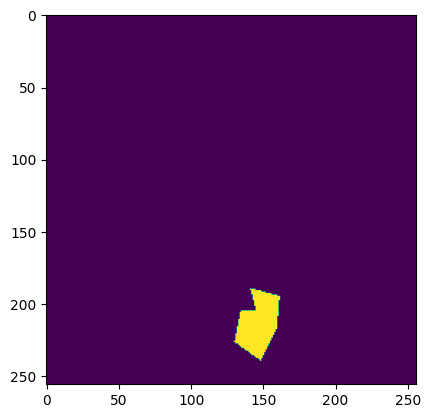

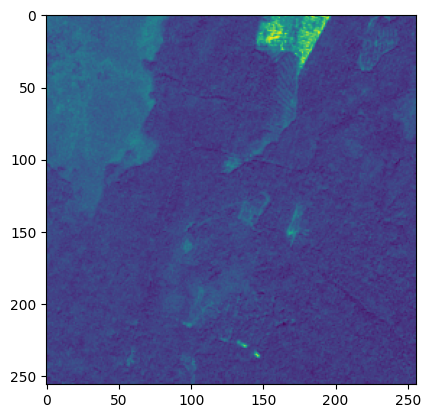

In [16]:
show_img(io.imread(TILE)[:,:,0])
show_img(io.imread(TILE)[:,:,2])

In [9]:

dataImg1, dataImg2 = dict(), dict()

with rasterio.open(FILE1) as dataset1:
        dataImg1['img'] = dataset1.read()
        dataImg1['bounds'] = dataset1.bounds
        dataImg1['coordinatesType'] = dataset1.crs
        dataImg1['transform'] = dataset1.transform

with rasterio.open(FILE2) as dataset2:
        dataImg2['img'] = dataset2.read()
        dataImg2['bounds'] = dataset2.bounds
        dataImg2['coordinatesType'] = dataset2.crs
        dataImg2['transform'] = dataset2.transform

RasterioIOError: output2_1.tif: No such file or directory

BoundingBox(left=454430.0, bottom=6401800.0, right=456990.0, top=6404360.0)
(1, 256, 256, 16)


/tmp/ipykernel_20701/1189039168.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


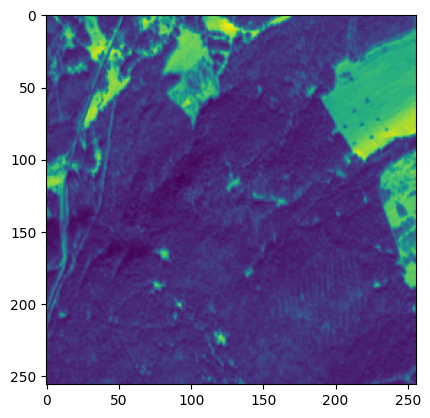

In [ ]:
# from image_preparation import prepareImage, prepareMask, resizeImage
# from polygons_preparation import simplifyPolygons,restorePolygonCoords

img1, img2 = np.transpose(dataImg1['img'], axes=(1, 2, 0)), np.transpose(dataImg2['img'], axes=(1, 2, 0))

# show_img(img1[:,:,6])
bounds = dataImg1['bounds']
print(bounds)
# Сжатие изображения до 256x256
# img1_resized = resizeImage(np.transpose(img1, axes=(2, 0, 1)), (256,256))
# img2_resized = resizeImage(np.transpose(img2, axes=(2, 0, 1)), (256,256))

concatedImage = np.concatenate((img1,img2), axis=2)

preparedImage = prepare_image(concatedImage)[np.newaxis, ...]  # (1, 256, 256, 16)
print(preparedImage.shape)

show_img(preparedImage[0][:,:,1])

In [ ]:
# img = prepare_image(io.imread(allTiles[0]))
# img.shape

In [ ]:


import onnx

# Загрузка ONNX модели
onnx_model = onnx.load('model_unet.onnx')

# Проверка модели
onnx.checker.check_model(onnx_model)


import onnxruntime
model_path = 'model_unet.onnx'
session = onnxruntime.InferenceSession(model_path)



# Получение имен входных и выходных узлов модели
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Выполнение предсказания
result = session.run([output_name], {input_name: preparedImage})

# Результат предсказания
print(result[0].shape)
print(np.unique(result[0][0]))


(1, 256, 256, 1)
[0.00000000e+00 2.98023224e-08 5.96046448e-08 8.94069672e-08
 1.19209290e-07 1.49011612e-07 1.78813934e-07 2.08616257e-07
 2.38418579e-07 2.68220901e-07 2.98023224e-07 3.27825546e-07
 3.57627869e-07 3.87430191e-07 4.17232513e-07 4.47034836e-07
 4.76837158e-07 5.06639481e-07 5.36441803e-07 6.25848770e-07
 6.85453415e-07 7.45058060e-07 7.74860382e-07 8.34465027e-07
 8.64267349e-07 1.01327896e-06 1.13248825e-06 1.19209290e-06
 1.25169754e-06 1.28149986e-06 1.37090683e-06 1.54972076e-06
 1.57952309e-06 1.60932541e-06 1.72853470e-06 1.81794167e-06
 2.47359276e-06 2.50339508e-06 2.56299973e-06 2.77161598e-06
 2.92062759e-06 3.01003456e-06 3.06963921e-06 3.63588333e-06
 3.69548798e-06 3.72529030e-06 3.87430191e-06 4.26173210e-06
 4.52995300e-06 4.67896461e-06 4.76837158e-06 4.94718552e-06
 5.12599945e-06 6.13927841e-06 6.16908073e-06 6.22868538e-06
 6.43730164e-06 6.55651093e-06 6.73532486e-06 6.88433647e-06
 7.03334808e-06 7.12275505e-06 7.18235970e-06 7.86781311e-06
 8.5830

2025-05-15 20:20:56.505627829 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-05-15 20:20:56.505666979 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-05-15 20:20:56.505674714 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute
2025-05-15 20:20:56.505681823 [W:onnxruntime:Default, upsamplebase.h:101 UpsampleBase] `tf_half_pixel_for_nn` is deprecated since opset 13, yet this opset 13 model uses the deprecated attribute


/tmp/ipykernel_20701/1189039168.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


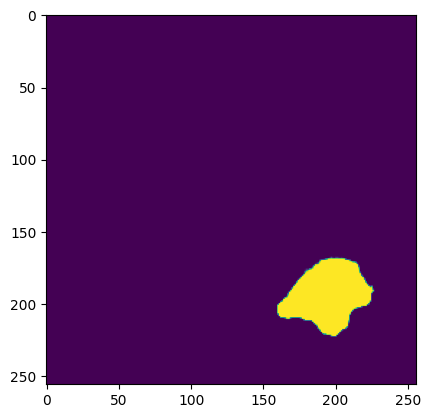

In [ ]:
show_img(result[0][0])

[0 1]


/tmp/ipykernel_20701/1189039168.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


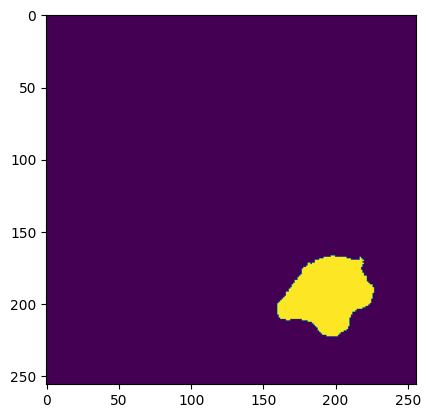

In [ ]:
test_mask = (result[0][0]*65536).astype(int)
test_mask[test_mask>1]=1
print(np.unique(test_mask))
show_img(test_mask)

In [ ]:
np.unique(test_mask)

array([0, 1])

In [ ]:
# img = io.imread(r'tiles_256_256_27_test\T38VNQ_pair_3_20200503_20210513\T38VNQ_pair_3_20200503_20210513_4523_3308_with_object.tif')

from skimage import measure
from simplification.cutil import simplify_coords, simplify_coords_vw

def getPolygons(mask,level = 0.5):
    """
    mask -> two dims (example: (256,256))
    """
    polygons = measure.find_contours(mask, level=level)
    for polygon in polygons:
        for i in range(polygon.shape[0]):
            polygon[i,1], polygon[i,0] =  polygon[i,0], polygon[i,1]
    return polygons

def simplifyPolygons(mask, epsilon = 50):
    polygons = getPolygons(mask)
    for polygon in polygons:
        polygon = simplify_coords_vw(polygon,epsilon) #Висвалингам-Уатт
    return polygons

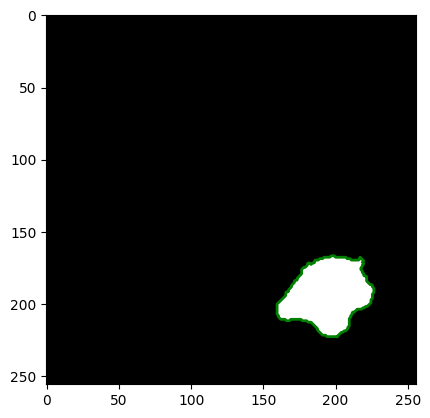

In [ ]:
contours = simplifyPolygons(test_mask[:,:,0])
fig, ax = plt.subplots()
ax.imshow(test_mask, cmap="gray")

for contour in contours:
    # print(contour.shape)
    # break
    ax.plot(contour[:,0], contour[:,1], linewidth=2, color="green")

plt.show()

In [ ]:
len(contours),contours[0].shape

(1, (261, 2))